# Import librarys and initialize whit Google credential

In [7]:
!conda install -c conda-forge geemap
!conda install -c conda-forge eemont


Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.



In [8]:
import ee, eemont, geemap
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd
from matplotlib import pyplot as plt

In [2]:
ee.Initialize()
Map = geemap.Map()

In [9]:
eemont.__version__

'0.2.5'

## set work directory to better manage of information

In [10]:
import os
g = os.getcwd()
g
path = 'D:\\repos\\CIAT\\Satellite_Time_series'
os.chdir(path)

In [24]:
ROI1 = gpd.read_file('Data\map_granja01_JO.geojson')
ROI2 = gpd.read_file('Data\map_granja02_JV.geojson')
# ROI1 = gmp.geopandas_to_ee(ROI1)
# ROI2 = gmp.geopandas_to_ee(ROI2)
# eemont.listIndices()


In [25]:
# search images Sentinel 2 since January 2019 to Agust 2020 in the Region Of Interes (ROI have convexhull)
def FT_Satellite(sensor,ROI,data_ini = '2019-01-01',data_end = '2021-07-30',VIs=['NDVI','GNDVI']):
      '''
      sensor is the satellite image to select:
      S2_SR = SENTINEL 2 REFLECTANCE
      S1_GRD = SENTINEL 1 RADAR

      return Dataframe with VIs by each plot
      '''
      ROI = geemap.geopandas_to_ee(ROI)
      if sensor == "S2_SR" or sensor == "S1_GRD" :
            S2 = (ee.ImageCollection('COPERNICUS/'+sensor)
                  .filterDate(data_ini,data_end)
                  .filterBounds(ROI)
                  .maskClouds()
                  .scale()
                  .index(VIs))
      ts = S2.getTimeSeriesByRegion(reducer = [ee.Reducer.mean(),ee.Reducer.median()],
                              geometry = ROI,
                              bands = VIs,
                              scale = 10)
      return geemap.ee_to_pandas(ts)

In [31]:
vis = ['kNDVI','NDVI','GNDVI']
tsPandas = FT_Satellite("S2_SR", ROI1, VIs=vis)

In [32]:
tsPandas[tsPandas == -9999] = np.nan
tsPandas['date'] = pd.to_datetime(tsPandas['date'],infer_datetime_format = True)

In [33]:
tsPandas = pd.melt(tsPandas,
                    id_vars = ['reducer','date'],
                    value_vars =vis,
                    var_name = 'Index',
                    value_name = 'Value')

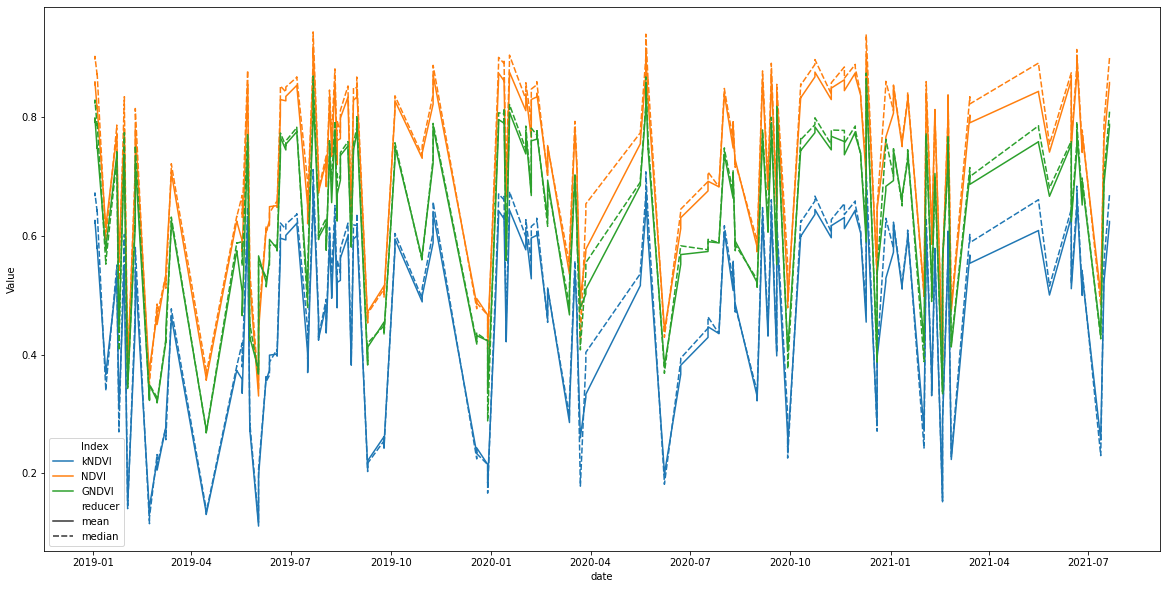

In [34]:
plt.figure(figsize = (20,10))
sns.lineplot(data = tsPandas,
            x = 'date',
            y = 'Value',
            hue = 'Index',
            style = 'reducer')